# Asynchronous Processing

While many parallel applications can be described as maps, some can be more complex.
In this section we look at the asynchronous `concurrent.futures` interface,
which provides a simple API for ad-hoc parallelism.
This is useful for when your computations don't fit a regular pattern.

### Executor.submit

The `submit` method starts a computation in a separate thread or process and immediately gives us a `Future` object that refers to the result.  At first, the future is pending.  Once the function completes the future is finished. 

We collect the result of the task with the `.result()` method,
which does not return until the results are available.

In [1]:
%%time
from time import sleep

def slowadd(a, b, delay=1):
    sleep(delay)
    return a + b

slowadd(1,1)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1 s


In [2]:
from concurrent.futures import ThreadPoolExecutor

e = ThreadPoolExecutor()
future = e.submit(slowadd, 1, 2)
future

<Future at 0x7fe60477f9e8 state=running>

In [3]:
future.result()

3

### Submit many tasks, receive many futures

Because submit returns immediately we can submit many tasks all at once and they will execute in parallel.

In [4]:
%%time
results = [slowadd(i, i, delay=1) for i in range(8)]
print(results)

[0, 2, 4, 6, 8, 10, 12, 14]
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 8.01 s


In [9]:
%%time
e = ThreadPoolExecutor()
futures = [e.submit(slowadd, i, i, delay=1) for i in range(8)]
results = [f.result() for f in futures]
print(results)

[0, 2, 4, 6, 8, 10, 12, 14]
CPU times: user 0 ns, sys: 8 ms, total: 8 ms
Wall time: 1 s


*  Submit fires off a single function call in the background, returning a future.  
*  When we combine submit with a single for loop we recover the functionality of map.  
*  When we want to collect our results we replace each of our futures, `f`, with a call to `f.result()`
*  We can combine submit with multiple for loops and other general programming to get something more general than map.

### Exercise 7.1

Parallelize the following code with e.submit

1.  Replace the `results` list with a list called `futures`
2.  Replace calls to `slowadd` and `slowsub` with `e.submit` calls on those functions
3.  At the end, block on the computation by recreating the `results` list by calling `.result()` on each future in the `futures` list.

In [10]:
%%time
from time import sleep

def slowadd(a, b, delay=1):
    sleep(delay)
    return a + b

def slowsub(a, b, delay=1):
    sleep(delay)
    return a - b

results = []
for i in range(4):
    for j in range(4):
        if i < j:
            results.append(slowadd(i, j, delay=1))
        elif i > j:
            results.append(slowsub(i, j, delay=1)) 
            
print(results)

[1, 2, 3, 1, 3, 4, 2, 1, 5, 3, 2, 1]
CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 12 s


In [13]:
%%time
from time import sleep
from concurrent.futures import ThreadPoolExecutor

def slowadd(a, b, delay=1):
    sleep(delay)
    return a + b

def slowsub(a, b, delay=1):
    sleep(delay)
    return a - b

e = ThreadPoolExecutor()

futures = []
for i in range(4):
    for j in range(4):
        if i < j:
            futures.append(e.submit(slowadd,i, j, delay=1))
        elif i > j:
            futures.append(e.submit(slowsub,i, j, delay=1)) 
            
results = [ f.result() for f in futures]
print(results)

[1, 2, 3, 1, 3, 4, 2, 1, 5, 3, 2, 1]
CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 1.01 s


## Extract daily stock data from google

In [20]:
import os  # library to get directory and file paths
import tarfile # this module makes possible to read and write tar archives

def extract_data(name, where):
    datadir = os.path.join(where,name)
    if not os.path.exists(datadir):
       print("Extracting data...")
       tar_path = os.path.join(where, name+'.tgz')
       with tarfile.open(tar_path, mode='r:gz') as data:
          data.extractall(where)
            
extract_data('daily-stock','../data') # this function call will extract json files

Extracting data...


## Convert data to pandas DataFrames and save it in hdf5 files

[HDF5](https://portal.hdfgroup.org/display/support) is a data model, library, and file format for storing and managing data. This format is widely used and is supported by many languages and platforms.

In [5]:
import json
import pandas as pd
import os, glob

here = os.getcwd()
datadir = os.path.join(here,'..','data','daily-stock')
filenames = sorted(glob.glob(os.path.join(datadir, '*.json')))
filenames

['/home/navaro_p/big-data/notebooks/../data/daily-stock/aet.json',
 '/home/navaro_p/big-data/notebooks/../data/daily-stock/afl.json',
 '/home/navaro_p/big-data/notebooks/../data/daily-stock/aig.json',
 '/home/navaro_p/big-data/notebooks/../data/daily-stock/al.json',
 '/home/navaro_p/big-data/notebooks/../data/daily-stock/amgn.json',
 '/home/navaro_p/big-data/notebooks/../data/daily-stock/avy.json',
 '/home/navaro_p/big-data/notebooks/../data/daily-stock/b.json',
 '/home/navaro_p/big-data/notebooks/../data/daily-stock/bwa.json',
 '/home/navaro_p/big-data/notebooks/../data/daily-stock/ge.json',
 '/home/navaro_p/big-data/notebooks/../data/daily-stock/hal.json',
 '/home/navaro_p/big-data/notebooks/../data/daily-stock/hp.json',
 '/home/navaro_p/big-data/notebooks/../data/daily-stock/hpq.json',
 '/home/navaro_p/big-data/notebooks/../data/daily-stock/ibm.json',
 '/home/navaro_p/big-data/notebooks/../data/daily-stock/jbl.json',
 '/home/navaro_p/big-data/notebooks/../data/daily-stock/jpm.json',

### Sequential version

In [7]:
%%time
from concurrent.futures import ProcessPoolExecutor
import json
import pandas as pd

def load_parse_store(fn):
    
    with open(fn) as f:
        data = [json.loads(line) for line in f] # load 
        
    df = pd.DataFrame(data) # parse 
    
    out_filename = fn[:-5] + '.h5'
    df.to_hdf(out_filename, '/data') # store
    print("Finished : %s" % (out_filename.split(os.path.sep)[-1]))
    
    return True

with ProcessPoolExecutor() as pool:
    
    results = pool.map(load_parse_store, filenames)
    

Finished : al.h5
Finished : aig.h5
Finished : afl.h5
Finished : aet.h5
Finished : avy.h5
Finished : amgn.h5
Finished : bwa.h5
Finished : b.h5
Finished : ge.h5
Finished : hal.h5
Finished : hp.h5
Finished : hpq.h5
Finished : ibm.h5
Finished : jbl.h5
Finished : luv.h5
Finished : jpm.h5
Finished : met.h5
Finished : pcg.h5
Finished : usb.h5
Finished : tgt.h5
Finished : xom.h5
CPU times: user 44 ms, sys: 20 ms, total: 64 ms
Wall time: 24.3 s


### Exercise 7.2

Parallelize the loop above using `ProcessPoolExecutor` and `map`.

## Read files and load dataframes.

In [8]:
filenames = sorted(glob.glob(os.path.join('..','data', 'daily-stock', '*.h5')))
series ={}
for fn in filenames:
    series[fn] = pd.read_hdf(fn)['close']

## Application

Given our HDF5 files from the last section we want to find the two datasets with the greatest pair-wise correlation.  This forces us to consider all $n\times(n-1)$ possibilities.


In [9]:
%%time

results = {}

for a in filenames:
    for b in filenames:
        if a != b:
            results[a, b] = series[a].corr(series[b])
            
((a, b), corr) = max(results.items(), key=lambda kv: kv[1])
print("%s matches with %s with correlation %f" % (a, b, corr))

../data/daily-stock/aet.h5 matches with ../data/daily-stock/luv.h5 with correlation 0.941318
CPU times: user 692 ms, sys: 8 ms, total: 700 ms
Wall time: 714 ms


We use matplotlib to visually inspect the highly correlated timeseries

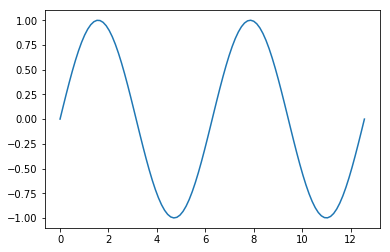

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 4*np.pi, 100 )
plt.plot( x, np.sin(x))

(array([11., 12.,  8.,  7., 10., 13., 12., 11.,  8.,  8.]),
 array([0.0124888 , 0.11117413, 0.20985947, 0.3085448 , 0.40723013,
        0.50591546, 0.60460079, 0.70328612, 0.80197146, 0.90065679,
        0.99934212]),
 <a list of 10 Patch objects>)

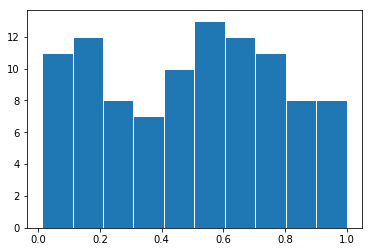

In [23]:
plt.hist(np.random.random(100), ec='w')

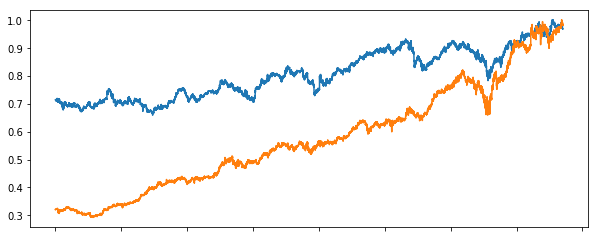

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(series[a]/series[a].max())
plt.plot(series[b]/series[b].max())
plt.xticks(visible=False);

## Analysis

This computation starts out by loading data from disk. We already know how to parallelize it:

```python
series = {}
for fn in filenames:
    series[fn] = pd.read_hdf(fn)['x']
```

It follows with a doubly nested for loop with an if statement.  

```python
results = {}
for a in filenames:
    for b in filenames:
        if a != b:
            results[a, b] = series[a].corr(series[b])
```

It *is* possible to solve this problem with `map`, but it requires some cleverness.  Instead we'll learn `submit`, an interface to start individual function calls asynchronously.

It finishes with a reduction on small data.  This part is fast enough.

```python
((a, b), corr) = max(results.items(), key=lambda kv: kv[1])
```

In [30]:
%%time

from concurrent.futures import ProcessPoolExecutor as PoolExecutor


e = PoolExecutor()

def corr( serie_a, serie_b):
    
    return serie_a.corr(serie_b)

futures = {}

for a in filenames:
    for b in filenames:
        if a != b:
            futures[a, b] = e.submit( corr, series[a], series[b])
            
results = {k : f.result() for k, f in futures.items()}            

            
((a, b), corr) = max(results.items(), key=lambda kv: kv[1])
print("%s matches with %s with correlation %f" % (a, b, corr))



../data/daily-stock/aet.h5 matches with ../data/daily-stock/luv.h5 with correlation 0.941318
CPU times: user 1.48 s, sys: 1.55 s, total: 3.03 s
Wall time: 3.22 s


### Exercise 7.3
- Parallelize pair-wise correlations with `e.submit`
- Implement two versions one using Processes, another with Threads by replacing `e` with a ProcessPoolExecutor:

#### Threads

```python
from concurrent.futures import ThreadPoolExecutor
e = ThreadPoolExecutor(4)
```

#### Processes

```python
from concurrent.futures import ProcessPoolExecutor
e = ProcessPoolExecutor(4)
```

- How does performance vary? 

Some conclusions about futures
----------------------------

*  `submit` functions can help us to parallelize more complex applications
*  It didn't actually speed up the code very much
*  Threads and Processes give some performance differences
*  This is not very robust.